In [108]:
import h3
import rasterio 
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pydeck as pdk
from rasterio.plot import show

In [143]:
def raster_to_df(raster_file):
    """
    Need to revise this process! 
    The input raster needs to already be in epsg:4326 in order for this to work. This means for now the suitability critieria raster layers
    (e.g. distance to farm etc.) need to be exported first as a raster layer without inf value (replace inf with zero for background values). 
    Then the non-inf raster layer should be imported to ArcGis to be reprojected into epsg:4326.  
    """
    with rasterio.open(raster_file) as src:
        band1 = src.read(1)
        # bbox = src.bounds
        print(src.meta)
        cols, rows = np.meshgrid(np.arange(band1.shape[1]), np.arange(band1.shape[0]))
        xs, ys = rasterio.transform.xy(src.transform, rows, cols)
        lons = np.array(xs)
        lats = np.array(ys)
    
    # Flatten the arrays and create a DataFrame
    df = pd.DataFrame({
       'lat': lats.flatten(),
       'lon': lons.flatten(),
       'value': band1.flatten()})
    
    # Filter out no-data values (if no-data values are zero)
    df = df[df['value'] != src.nodatavals[0]]


    # Filter out no-data values (if no-data values are inf)
    # df.replace([np.inf, -np.inf], np.nan, inplace=True)
    # # Drop rows with NaN
    # df.dropna(inplace=True)
    
    return band1, df

In [132]:
# raster_file = "./raster/d_to_farm_complete_ckdtree_50.tif"
#'/Users/wenyuc/Desktop/UT/data/raster/d_to_road_4326.tif'
raster_file = "/Users/User/Desktop/BIOZE/new_rasters/d_to_road_complete_ckdtree_50_nonzero_4326.tif"
#'./raster/d_to_road_complete_ckdtree_50.tif'

In [144]:
band1, df = raster_to_df(raster_file)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 2150, 'height': 1095, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0003512126805009149, 0.0, 6.3233234969510566,
       0.0, -0.00035121268050091527, 52.49930676229287)}


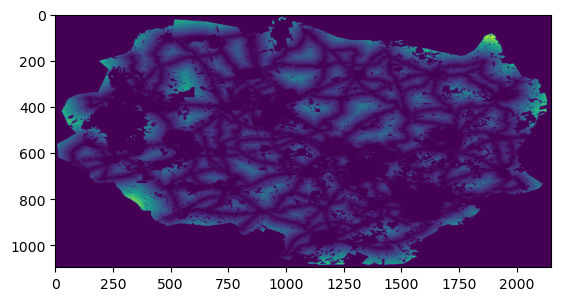

<Axes: >

In [146]:
show(band1)

In [135]:
APERTURE_SIZE = 9
hex_col = 'hex'+str(APERTURE_SIZE)

In [147]:
# find hexs containing the points
df[hex_col] = df.apply(lambda x: h3.geo_to_h3(x.lat, x.lon, APERTURE_SIZE),1)

In [148]:
df.head()

,lat,lon,value,hex9
26783,52.494917,6.668741,5918.953613,891f1689663ffff
26784,52.494917,6.669092,5918.953613,891f1689663ffff
26785,52.494917,6.669444,5885.018066,891f1689663ffff
28932,52.494565,6.668390,5916.811035,891f1689663ffff
28933,52.494565,6.668741,5882.437988,891f1689663ffff


In [105]:
# (hex_small['hex9'].isin(hex_df['h3'])).sum()

0

In [151]:
hex_df = df.groupby(hex_col)['value'].mean().to_frame('value').reset_index()

In [154]:
import matplotlib.cm as cm
import matplotlib.colors as colors

def generate_fill_color(df, column_name, color_map='viridis'):
   """
   Generates a Pydeck-compatible color array based on the values in a DataFrame column.


   Parameters:
   - df: DataFrame containing the data
   - column_name: Name of the column to use for coloring
   - color_map: Matplotlib colormap name to use for coloring (default is 'viridis')


   Returns:
   - fill_color_array: A list of colors corresponding to the values in the specified column
   """
   # Extract values from the specified column
   values = df[column_name]


   # Create a colormap
   colormap = cm.get_cmap(color_map)


   # Normalize values to range [0, 1]
   norm = colors.Normalize(vmin=values.min(), vmax=values.max())


   # Map values to colors
   color_mapper = cm.ScalarMappable(norm=norm, cmap=colormap)
   fill_color_array = color_mapper.to_rgba(values)

   # Convert RGBA values to hex
   fill_color_array_hex = [colors.to_hex(color) for color in fill_color_array]


   return fill_color_array_hex


In [155]:
fill_color = generate_fill_color(hex_df, 'value')

C:\Users\User\AppData\Local\Temp\ipykernel_7076\2406969335.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(color_map)


In [84]:
hex_df.to_csv('./hex/d_to_farm_hex_complete.csv')

In [85]:
hex_9 = pd.read_csv("./hex/df_hex_9.csv")

In [88]:
hex_small = pd.read_csv("./hex/d_to_road_hex.csv")

In [152]:
hex_df

,hex9,value
0,891f1600003ffff,3142.992188
1,891f160000bffff,2914.883301
2,891f160000fffff,3215.636963
3,891f1600013ffff,2888.750977
4,891f1600017ffff,3231.288086
...,...,...
14822,891f16d5ec7ffff,1253.145020
14823,891f16d5ecbffff,626.039734
14824,891f16d5ecfffff,782.215027
14825,891f16d5ed3ffff,1483.049805


In [89]:
hex_small

,Unnamed: 0,hex9,Value
0,0,891f1618003ffff,2039.772100
1,1,891f161800bffff,2065.342000
2,2,891f1618013ffff,1821.108000
3,3,891f1618017ffff,2021.018800
4,4,891f161801bffff,1820.216600
...,...,...,...
280,280,891f161b627ffff,90.034520
281,281,891f161b62bffff,35.175900
282,282,891f161b62fffff,24.896670
283,283,891f161b633ffff,142.916430


In [40]:
hex_9

,Unnamed: 0,hex9,Value,lat,lng,suitability
0,0,891f1600003ffff,0.599844,52.340083,7.038925,60.0
1,1,891f160000bffff,0.631382,52.337392,7.036908,63.1
2,2,891f160000fffff,0.591946,52.337959,7.041762,59.2
3,3,891f1600013ffff,0.633506,52.342208,7.036088,63.4
4,4,891f1600017ffff,0.589545,52.342775,7.040941,59.0
...,...,...,...,...,...,...
14933,14933,891f16d5ec7ffff,0.835780,52.468018,6.506818,83.6
14934,14934,891f16d5ecbffff,0.853523,52.464737,6.499983,85.4
14935,14935,891f16d5ecfffff,0.843583,52.465326,6.504826,84.4
14936,14936,891f16d5ed3ffff,0.814119,52.469533,6.499124,81.4


In [157]:
# Define a layer to display on a map
layer = pdk.Layer(
    "H3HexagonLayer",
    hex_df,
    pickable=True,
    stroked=True,
    filled=True,
    extruded=False,
    opacity=0.9,
    get_hexagon="hex9",
    get_fill_color = [255, 255, 255], 
    get_line_color=[255, 255, 255],
    line_width_min_pixels=2)

# Set the viewport location
view_state = pdk.ViewState(longitude=6.747489560596507, latitude=52.316862707395394, zoom=9, bearing=0, pitch=0)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip={"text": "Count: {value}"})
r.to_html("h3_hexagon_layer.html")

In [24]:
def cell_to_shapely(cell):
    coords = h3.h3_to_geo_boundary(cell)
    flipped = tuple(coord[::-1] for coord in coords)
    return Polygon(flipped)

In [25]:
hex_geoms = hex['hex'].apply(lambda x: cell_to_shapely(x))
h3_gdf = gpd.GeoDataFrame(data=hex, geometry=hex_geoms, crs=4326)
h3_gdf.head()

,hex,Value,geometry
0,89000111587ffff,3702.986328,"POLYGON ((34.14719 79.95632, 34.15500 79.95740..."
1,8900011196bffff,3772.316406,"POLYGON ((34.15255 80.04126, 34.16043 80.04234..."
2,89001c86c8bffff,3777.482422,"POLYGON ((44.15541 80.03963, 44.16442 80.04047..."
3,89001c94e63ffff,3772.738770,"POLYGON ((44.15192 79.95475, 44.16085 79.95558..."
4,89001e09137ffff,3731.632812,"POLYGON ((54.15657 79.95653, 54.16638 79.95709..."


<Axes: >

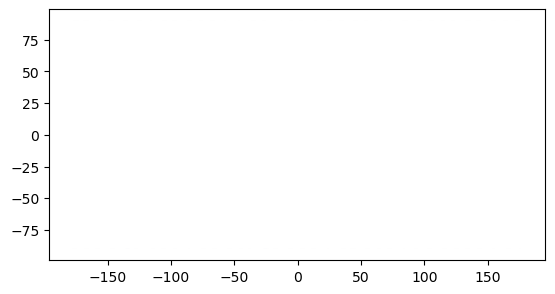

In [26]:
h3_gdf.plot()

In [124]:
with rasterio.open(r'./raster/d_to_road_complete_ckdtree_50.tif') as src:
    band1 = src.read(1)

In [125]:
band1[np.isinf(band1)] = 0

In [129]:
# Open the original raster file
with rasterio.open(r'./raster/d_to_road_complete_ckdtree_50.tif') as src:
    # Retrieve the metadata from the original raster file
    profile = src.profile
    # Update the metadata for the new raster file with the data from distances_farm
    profile.update(
        dtype=rasterio.float32,
        count=1
    )

    # Save the distances_farm array as a new raster file
    # \Users\User\Desktop\BIOZE\new_rasters
    with rasterio.open('/Users/User/Desktop/BIOZE/new_rasters/d_to_road_complete_ckdtree_50_nonzero.tif', 'w', **profile) as dst:
        dst.write(band1, 1)

In [119]:
farm_hex = pd.read_csv('./hex/d_to_farm_hex.csv')
road_hex = pd.read_csv('./hex/d_to_road_hex.csv')

In [122]:
farm_hex

,Unnamed: 0,hex9,Value
0,0,891f1618003ffff,2381.4856
1,1,891f161800bffff,2337.3857
2,2,891f1618013ffff,2218.8733
3,3,891f1618017ffff,2436.8770
4,4,891f161801bffff,2114.2710
...,...,...,...
280,280,891f161b627ffff,2913.5730
281,281,891f161b62bffff,3391.3794
282,282,891f161b62fffff,3089.9436
283,283,891f161b633ffff,3285.7136


In [121]:
road_hex

,Unnamed: 0,hex9,Value
0,0,891f1618003ffff,2039.772100
1,1,891f161800bffff,2065.342000
2,2,891f1618013ffff,1821.108000
3,3,891f1618017ffff,2021.018800
4,4,891f161801bffff,1820.216600
...,...,...,...
280,280,891f161b627ffff,90.034520
281,281,891f161b62bffff,35.175900
282,282,891f161b62fffff,24.896670
283,283,891f161b633ffff,142.916430


In [148]:
fake_hex = road_hex.copy()
fake_hex['Value'] = np.random.randint(100,1001, 285)

In [150]:
fake_hex.to_csv('./hex/fake_hex.csv')

### Fuzzify the variables

In [126]:
# Transform distance to farm and road into numpy array
d_to_farm = np.array(farm_hex['Value'])
d_to_road = np.array(road_hex['Value'])

In [127]:
fuzzy_farm = np.maximum(0, 1 - (d_to_farm - d_to_farm.min()) / (d_to_farm.max() - d_to_farm.min()))
fuzzy_road = np.maximum(0, 1 - (d_to_road - d_to_road.min()) / (d_to_road.max() - d_to_road.min()))

In [ ]:
def fuzzify(df):
    df_array = np.array(df['Value'])
    fuzzified_array = np.maximum(0, 1 - (df_array - df_array.min()) / (df_array.max() - df_array.min()))
    return fuzzified_array

In [ ]:
def fuzzy_analysis_hex(*args, hex_df):
    # Fuzzy operation AND
    fuzzy = np.minimum(args)
    # # Find the indices of non-inf values in original raster layer
    # non_inf_indices = np.where(np.isfinite(og_raster))
    hex_df['fuzzy'] = fuzzy
    return hex_df

In [131]:
fuzzy = np.minimum(fuzzy_farm, fuzzy_road)

In [134]:
fuzzy_hex = farm_hex.copy()

In [135]:
fuzzy_hex

,Unnamed: 0,hex9,Value
0,0,891f1618003ffff,2381.4856
1,1,891f161800bffff,2337.3857
2,2,891f1618013ffff,2218.8733
3,3,891f1618017ffff,2436.8770
4,4,891f161801bffff,2114.2710
...,...,...,...
280,280,891f161b627ffff,2913.5730
281,281,891f161b62bffff,3391.3794
282,282,891f161b62fffff,3089.9436
283,283,891f161b633ffff,3285.7136


In [137]:
fuzzy_hex['fuzzy'] = fuzzy
fuzzy_hex = fuzzy_hex.drop(['Unnamed: 0', 'Value'], axis=1)

In [138]:
fuzzy_hex

,hex9,fuzzy
0,891f1618003ffff,0.043984
1,891f161800bffff,0.031908
2,891f1618013ffff,0.147255
3,891f1618017ffff,0.052841
4,891f161801bffff,0.147676
...,...,...
280,891f161b627ffff,0.164346
281,891f161b62bffff,0.022344
282,891f161b62fffff,0.111929
283,891f161b633ffff,0.053747


Text(0, 0.5, 'Frequency')

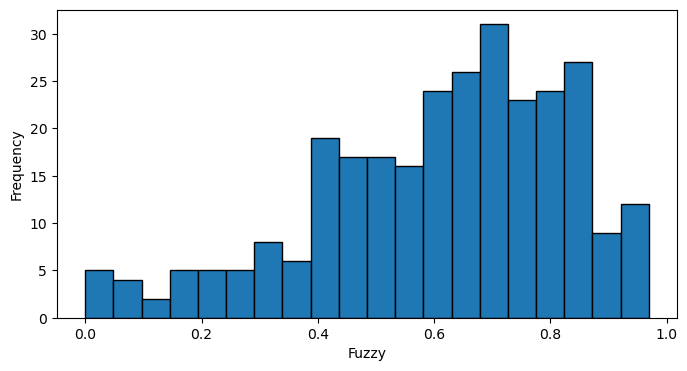

In [146]:
# Create subplots
plt.figure(figsize=(8, 4))
plt.hist(fuzzy, bins=20, edgecolor='black')
plt.xlabel('Fuzzy')
plt.ylabel('Frequency')

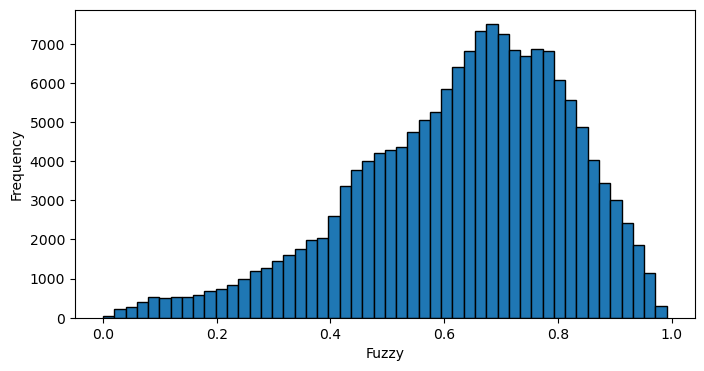

In [147]:
with rasterio.open("./raster/fuzzy_and_1.tif") as src:
    band1 = src.read(1)
    # Create subplots
    plt.figure(figsize=(8, 4))
    plt.hist(band1[np.isfinite(band1)], bins=50, edgecolor='black')
    plt.xlabel('Fuzzy')
    plt.ylabel('Frequency')

In [130]:
def fuzzy_analysis(*args, og_raster, og_raster_path, new_raster_path):
    """
    This is the fuzzy analysis function to perform on raster layer. 
    args: arrays of fuzzified criteria 
    """
    # Fuzzy operation AND
    fuzzy = np.minimum(args)
    # Find the indices of non-inf values in original raster layer
    non_inf_indices = np.where(np.isfinite(og_raster))
    
    if len(fuzzy) == len(non_inf_indices[0]):
        # Replace the non-inf values in original raster layer with fuzzy values
        m = np.copy(og_raster)
        m[non_inf_indices] = fuzzy
    else:
        print("Can not proceed")
    
    # Save the fuzzy array 
    with rasterio.open(og_raster_path) as src:
        profile = src.profile
        profile.update(dtype=rasterio.float32, count=1)
        with rasterio.open(new_raster_path, 'w', **profile) as dst:
            dst.write(m, 1)
    return fuzzy

In [2]:
farm_hex = pd.read_csv('./hex/d_to_farm_hex.csv')
road_hex = pd.read_csv('./hex/d_to_road_hex.csv')
fake_hex = pd.read_csv('./hex/fake_hex.csv')

In [3]:
def fuzzify(df):
    df_array = np.array(df['Value'])
    fuzzified_array = np.maximum(0, 1 - (df_array - df_array.min()) / (df_array.max() - df_array.min()))
    return fuzzified_array

def fuzzy_analysis_hex(*args):
    # Fuzzy operation AND
    fuzzy = np.minimum(args)
    return fuzzy 

In [5]:
fuzzy_farm = fuzzify(farm_hex)
fuzzy_road = fuzzify(road_hex)
fuzzy_fake = fuzzify(fake_hex)

In [6]:
all_arrays = {'Farm': fuzzy_farm, 'Road': fuzzy_road, 'Fake': fuzzy_fake}

In [13]:
# Create multiple arrays
array1 = np.array([1, 5, 3, 8])
array2 = np.array([2, 4, 1, 7])
array3 = np.array([0, 6, 2, 9])

# Store arrays in a list
array_list = [array1, array2, array3]

In [18]:
data_dict = {'Farm': array1,
             'City':array2,
             'Village': array3}

In [20]:
# Your list of keys
keys_to_extract = ['Farm', 'City']

In [21]:
# Extract arrays using a list comprehension
arrays_to_extract = [data_dict[key] for key in keys_to_extract]

# Now arrays_to_extract contains the arrays corresponding to the keys in the list
for key, arr in zip(keys_to_extract, arrays_to_extract):
    print(f"{key}: {arr}")

Farm: [1 5 3 8]
City: [2 4 1 7]


In [23]:
# Use a loop to compute the element-wise minimum
result_array = array_list[0]  # Initialize with the first array

In [26]:
for arr in array_list[1:]:
    result_array = np.minimum(result_array, arr)

print("Original Arrays:")
for i, arr in enumerate(array_list, start=1):
    print(f"Array {i}:", arr)

print("\nElement-wise Minimum:")
print("Result Array:", result_array)

Original Arrays:
Array 1: [1 5 3 8]
Array 2: [2 4 1 7]
Array 3: [0 6 2 9]

Element-wise Minimum:
Result Array: [0 4 1 7]


In [27]:
def fuzzify(df):
    df_array = np.array(df['Value'])
    fuzzified_array = np.maximum(0, 1 - (df_array - df_array.min()) / (df_array.max() - df_array.min()))
    return fuzzified_array

In [29]:
fuzzy_farm = fuzzify(farm_hex)

In [31]:
fuzzy_farm.shape

(285,)

In [32]:
farm_hex

,Unnamed: 0,hex9,Value
0,0,891f1618003ffff,2381.4856
1,1,891f161800bffff,2337.3857
2,2,891f1618013ffff,2218.8733
3,3,891f1618017ffff,2436.8770
4,4,891f161801bffff,2114.2710
...,...,...,...
280,280,891f161b627ffff,2913.5730
281,281,891f161b62bffff,3391.3794
282,282,891f161b62fffff,3089.9436
283,283,891f161b633ffff,3285.7136


In [33]:
df = farm_hex[['hex9']]
df

,hex9
0,891f1618003ffff
1,891f161800bffff
2,891f1618013ffff
3,891f1618017ffff
4,891f161801bffff
...,...
280,891f161b627ffff
281,891f161b62bffff
282,891f161b62fffff
283,891f161b633ffff
